In [48]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML

In [106]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=20

In [50]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [51]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [53]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[0 0 0 1 0 0 1 0 1 0 0 0 1 1 1 1 0 0 1 0 1 1 0 1 2 0 0 0 0 1 1 0]


In [54]:
# 68 * 32

In [55]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch[0])

tf.Tensor(
[[[161. 146. 151.]
  [147. 132. 137.]
  [143. 128. 133.]
  ...
  [162. 142. 151.]
  [163. 143. 152.]
  [164. 144. 153.]]

 [[146. 131. 136.]
  [147. 132. 137.]
  [145. 130. 135.]
  ...
  [163. 143. 152.]
  [164. 144. 153.]
  [165. 145. 154.]]

 [[145. 130. 135.]
  [147. 132. 137.]
  [147. 132. 137.]
  ...
  [162. 142. 151.]
  [163. 143. 152.]
  [163. 143. 152.]]

 ...

 [[180. 166. 166.]
  [182. 168. 168.]
  [182. 168. 168.]
  ...
  [174. 159. 164.]
  [171. 156. 161.]
  [169. 154. 159.]]

 [[173. 159. 159.]
  [180. 166. 166.]
  [183. 169. 169.]
  ...
  [177. 162. 167.]
  [173. 158. 163.]
  [170. 155. 160.]]

 [[160. 146. 146.]
  [172. 158. 158.]
  [179. 165. 165.]
  ...
  [178. 163. 168.]
  [175. 160. 165.]
  [172. 157. 162.]]], shape=(256, 256, 3), dtype=float32)


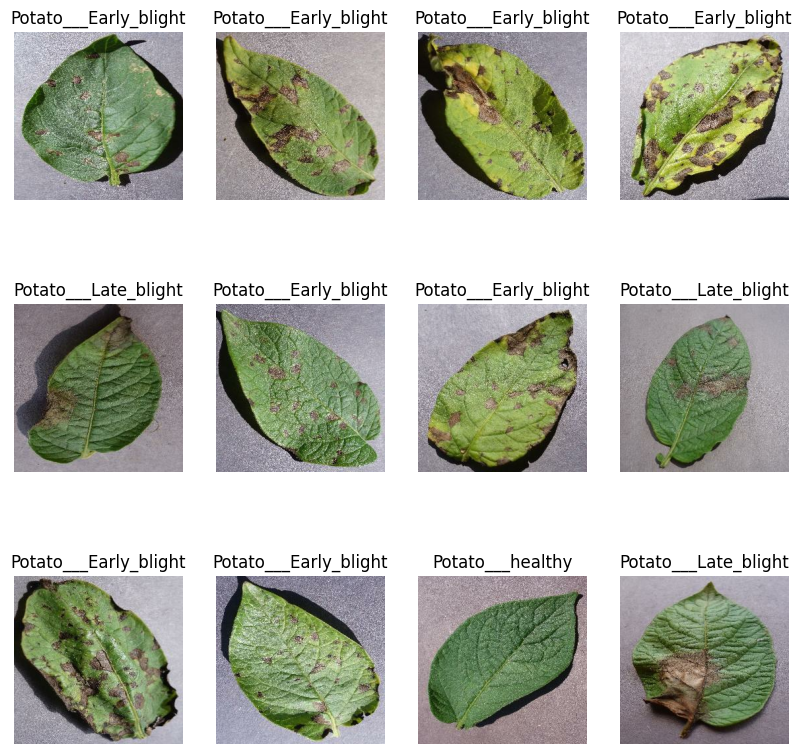

In [56]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")
    

In [8]:
# 80 train , 20 test  -> 10 validation , 10 test

In [9]:
train_size = 0.8

In [57]:
train_size = 0.8
len(dataset)*train_size
# 54 of 68  is 80percent

54.400000000000006

In [58]:
train_ds = dataset.take(54)
len(train_ds)

54

In [59]:
test_ds = dataset.skip(54)
len(test_ds)

14

In [60]:
val_size=0.1
len(dataset)*val_size

6.800000000000001

In [61]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [62]:

test_ds = test_ds.skip(6)
len(test_ds)

8

In [63]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [64]:
 train_ds, val_ds , test_ds = get_dataset_partitions_tf(dataset)

In [65]:
len(train_ds)

54

In [66]:
len(val_ds)

6

In [67]:
len(test_ds)

8

In [68]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [69]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [70]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [71]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

# MODEL

In [72]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_3 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d_5 (Conv2D)           (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d_5 (MaxPooling  (32, 127, 127, 32)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_6 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (32, 60, 60, 64)         

In [73]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [74]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=20,
)

Epoch 1/20
54/54 [==============================] - 50s 888ms/step - loss: 0.8544 - accuracy: 0.5307 - val_loss: 0.5984 - val_accuracy: 0.7500
Epoch 2/20
54/54 [==============================] - 47s 869ms/step - loss: 0.4792 - accuracy: 0.7963 - val_loss: 0.3368 - val_accuracy: 0.8490
Epoch 3/20
54/54 [==============================] - 47s 877ms/step - loss: 0.4175 - accuracy: 0.8125 - val_loss: 0.3997 - val_accuracy: 0.8438
Epoch 4/20
54/54 [==============================] - 53s 976ms/step - loss: 0.3222 - accuracy: 0.8733 - val_loss: 0.3648 - val_accuracy: 0.8281
Epoch 5/20
54/54 [==============================] - 57s 1s/step - loss: 0.2480 - accuracy: 0.8941 - val_loss: 0.1526 - val_accuracy: 0.9375
Epoch 6/20
54/54 [==============================] - 59s 1s/step - loss: 0.2328 - accuracy: 0.9138 - val_loss: 0.1673 - val_accuracy: 0.9115
Epoch 7/20
54/54 [==============================] - 59s 1s/step - loss: 0.1874 - accuracy: 0.9271 - val_loss: 0.1540 - val_accuracy: 0.9531
Epoch 8/

In [90]:
scores = model.evaluate(test_ds)

8/8 [==============================] - 1s 162ms/step - loss: 0.0397 - accuracy: 0.9883


In [91]:
scores

[0.03968413919210434, 0.98828125]

In [92]:
history

In [93]:
history.params

{'verbose': 1, 'epochs': 20, 'steps': 54}

In [94]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [95]:
history.history['loss'][:5] # show loss for first 5 epochs

[0.8544496893882751,
 0.4791548550128937,
 0.4174894690513611,
 0.3222077786922455,
 0.24802683293819427]

In [107]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

In [108]:
acc

[0.5306712985038757,
 0.7962962985038757,
 0.8125,
 0.8732638955116272,
 0.8940972089767456,
 0.9137731194496155,
 0.9270833134651184,
 0.9322916865348816,
 0.9484953880310059,
 0.9670138955116272,
 0.9704861044883728,
 0.9658564925193787,
 0.9577546119689941,
 0.9820601940155029,
 0.9461805820465088,
 0.9606481194496155,
 0.9739583134651184,
 0.9739583134651184,
 0.9785879850387573,
 0.9739583134651184]

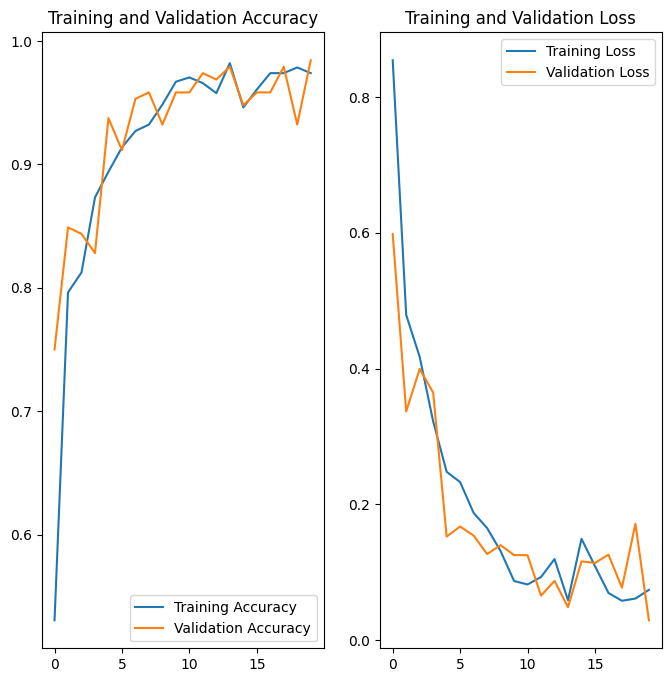

In [111]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: Potato___Early_blight
1/1 [==============================] - 0s 227ms/step
predicted label: Potato___Early_blight


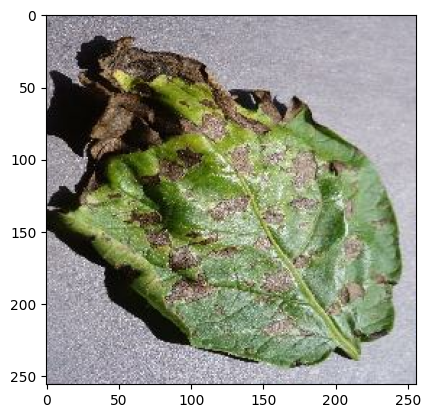

In [112]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [113]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 31ms/step


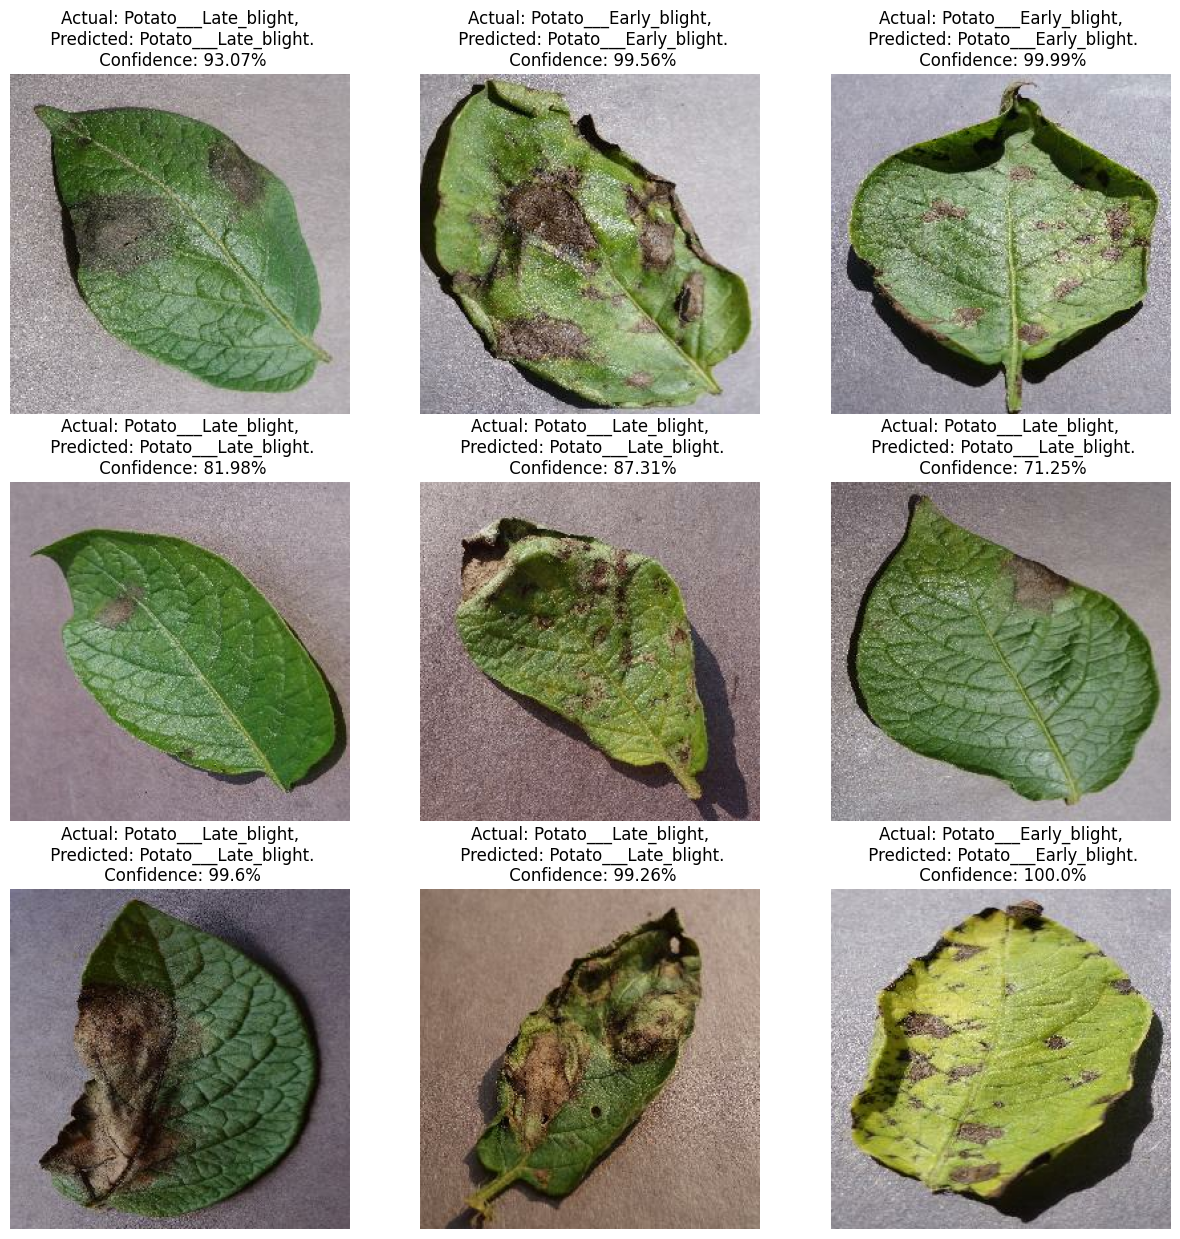

In [45]:

plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [114]:
import os
model_version=max([int(i) for i in os.listdir("../models") + [0]])+1
model.save(f"../models/{model_version}")

TypeError: this __dict__ descriptor does not support '_DictWrapper' objects

In [ ]:
model.save("../potatoes.h5")